# Programmatic and symbolic modelling 
This workshop primarily uses the `@reaction_network` DSL to create models. However, it is also possible to create the programmatically be assembling its components one by one. Here we will briefly demonstrate such a workflow.

## Creating a model without using the DSL

We will use a simple binding/dissociation model as our example. Here, `X` and `Y` binds at rate `kB` to form `XY`, while `XY` dissociates into `X` and `Y` at rate `kD`.

First we need to declare our:
- Independent variable: in this case time, `t`.
- Our species, `X`, `Y`, and `XY`.
- Our parameters `kB`, and `kD`.

We do this using the `@variables`, `@species`, and `@parameters` macros (the notation is here identical to how these are used as options within the DSL).

In [1]:
using Catalyst
@variables t
@species X(t) Y(t) XY(t)
@parameters kB kD;

Next we create our reactions using the `Reaction` function. Each reaction takes 5 arguments:
- The reaction rate.
- The substrates of the reaction.
- The products of the reaction.
- The stoichiometric coefficients of the substrates.
- The stoichiometric coefficients of the products.

We bundle our reactions together in a single vector and use it to create a `ReactionSystem` (which also takes the independent variable, `t`).

In [2]:
reactions = [Reaction(kB, [X, Y], [XY], [1,1], [1]),
             Reaction(kD, [XY], [X, Y], [1], [1,1])]
@named rs = ReactionSystem(reactions, t)

Model rs
States (3):
  X(t)
  Y(t)
  XY(t)
Parameters (2):
  kB
  kD

We use the `@named` macro to give our reaction system a name identical to the variable we store it in. That our models have names are typically irrelevant, but can sometimes be useful. We can check the name through `rs.name`:

In [3]:
rs.name

:rs

We can now simulate our model using teh same syntax as before. However, when the DSL is used, the component names (e.g. `X` and `kD`) are stored internally and we use `Symbol`s to determine the value of each component (e.g. `:X`). Now, since we have decalred the components using e.g. `@species X Y XY` these are variables that can be used directly:

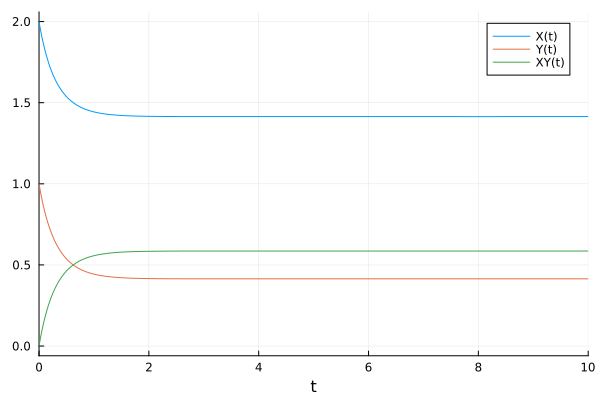

In [4]:
using OrdinaryDiffEq, Plots    # Here we use "OrdinaryDiffEq" instead of "DifferentialEquations". The former is a light-weight version of the latter, exporting ODE functionality only (and is thus quicker to import).

u0 = [X => 2.0, Y => 1.0, XY => 0.0]
tspan = (0.0, 10.0)
ps = [kD => 1.0, kB => 1.0]
oprob = ODEProblem(rs, u0, tspan, ps)
sol = solve(oprob, Tsit5())           # Automatic solver selection is a part of DifferentialEquations, so when using OrdinaryDiffEq we have to select one. Tsit5 works well for small non-stiff problems.
plot(sol)

## The symbolic backend
Catalyst builds on the ModelingToolkit.jl package modelling package. It, in turn represent all its parameters and variables using the Symbolics.jl computer algebraic system. This means that all Catalyst equations are symbolically represented, and we can do computational algebra on them. Internally, this can be used to speed up simulations in various ways.

Here, as an example, let's create an expression using our parameters

In [5]:
eq = (kB^2 - kD^2)/(kB-kD)

(kB^2 - (kD^2)) / (kB - kD)

We can now simplify this using the `simplify` function, creasing an easier expression.

In [6]:
simplify(eq)

kB + kD